In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from tensorflow.keras.layers import Input
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0
/device:GPU:0
Num GPUs Available:  1


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/cov_web_datset"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content/gdrive/MyDrive/cov_web_datset. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/gdrive/MyDrive/cov_web_datset'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [05:37,  7.34it/s]

(2481, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

In [ ]:
from keras.applications import Xception
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Conv2D, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
EPOCHS = 200
SIZE = 64
N_ch = 3

# Define the function to build the Xception-based model
def build_Xception():
    xception = Xception(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))  # Define the input tensor here
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = xception(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Multi-output
    output = Dense(2, activation='softmax', name='root')(x)

    # Create the model
    model = Model(input, output)

    optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

model = build_Xception()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('Xception_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)

datagen.fit(X_train)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_10 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                           

In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/200


<ipython-input-14-427914eb0244>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


31/31 [==============================] - ETA: 0s - loss: 0.9189 - accuracy: 0.5867
Epoch 1: val_loss improved from inf to 3.64010, saving model to Xception_Model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 50s 269ms/step - loss: 0.9189 - accuracy: 0.5867 - val_loss: 3.6401 - val_accuracy: 0.5191 - lr: 0.0030
Epoch 2/200
31/31 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.6462
Epoch 2: val_loss improved from 3.64010 to 0.89140, saving model to Xception_Model.hdf5
31/31 [==============================] - 6s 196ms/step - loss: 0.6844 - accuracy: 0.6462 - val_loss: 0.8914 - val_accuracy: 0.5594 - lr: 0.0030
Epoch 3/200
31/31 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7162
Epoch 3: val_loss did not improve from 0.89140
31/31 [==============================] - 5s 152ms/step - loss: 0.5651 - accuracy: 0.7162 - val_loss: 9.7239 - val_accuracy: 0.7183 - lr: 0.0030
Epoch 4/200
31/31 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.7994
Epoch 4: val_loss did not improve from 0.89140
31/31 [==============================] - 6s 185ms/step - loss: 0.4504 - accuracy: 0.7994 - val_loss:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

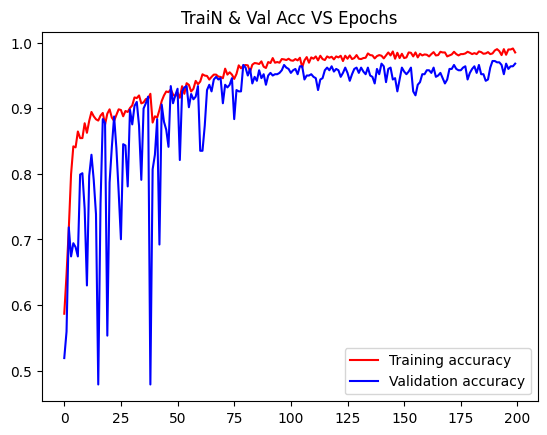

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

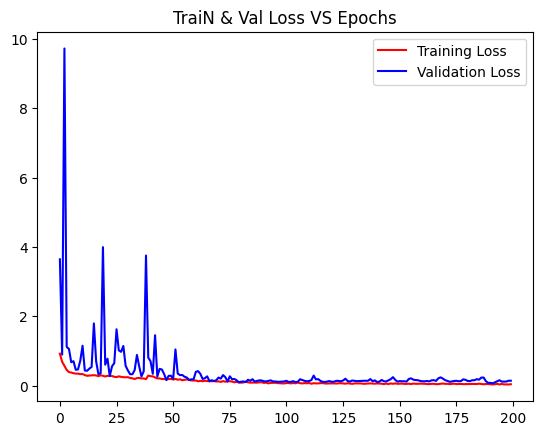

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
model.load_weights("Xception_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 0s 22ms/step - loss: 0.0651 - accuracy: 0.9698
Test Loss: 0.06508415192365646
Test accuracy: 96.98188900947571


16/16 [==============================] - 1s 20ms/step


Text(0.5, 1.0, 'Confusion Matrix')

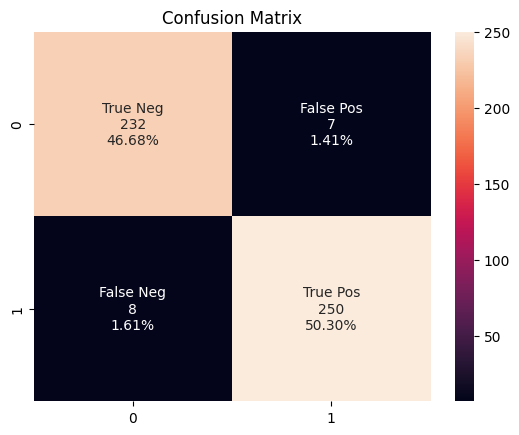

In [ ]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the pre-trained model
model_path = '/content/Xception_Model.hdf5'
model = load_model(model_path)

# Load and preprocess the image
path = "/content/gdrive/MyDrive/cov_web_datset/non-COVID/Non-Covid (10).png"
img = image.load_img(path, target_size=(64, 64))
img = image.img_to_array(img) / 255.0
img = np.array([img])

# Make predictions
predictions = model.predict(img)

# Set a threshold for binary classification
threshold = 0.5
if predictions[0][0] >= threshold:
    result = "COVID: Positive"
else:
    result = "COVID: Negative"

print(f'The image is classified as: {result}')


1/1 [==============================] - 1s 811ms/step
The image is classified as: COVID: Negative
